In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

/home/cakaltc1/Development/projects/github/py3_machine_learning/venv/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 189.9700 - val_loss: 172.1379
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 169.5538 - val_loss: 167.3556
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 166.4582 - val_loss: 165.4861
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 164.3147 - val_loss: 163.5742
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 162.8405 - val_loss: 162.8496
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 161.7086 - val_loss: 161.4092
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 160.7027 - val_loss: 160.7034
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 159.7531 - val_loss: 159.6894
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 158.8192 - val_loss: 159.0683
Epoch 10/50
60000/60000 [==============================] - 

In [19]:
# build a model to project inputs on the latent space
print(x.shape)
print(z_mean.shape)
encoder = Model(x, z_mean)

(?, 784)
(?, 2)


X_Test.Shape: (10000, 784)
X_Test_Encoded.Shape:  (10000, 2)
Y_Test:  10000


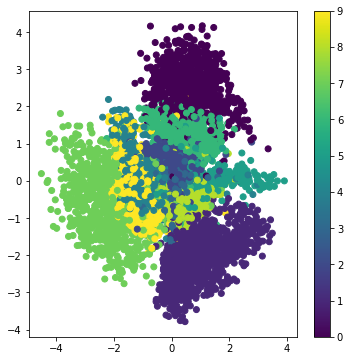

In [22]:
# display a 2D plot of the digit classes in the latent space
print('X_Test.Shape:', x_test.shape)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

print('X_Test_Encoded.Shape: ', x_test_encoded.shape)
print('Y_Test: ', len(y_test))

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [29]:

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
print('decoder_input.shape:', decoder_input.shape)

_h_decoded = decoder_h(decoder_input)
print('_h_decoded.shape:', _h_decoded.shape)

_x_decoded_mean = decoder_mean(_h_decoded)
print('_x_decoded_mean.shape:', _x_decoded_mean.shape)

generator = Model(decoder_input, _x_decoded_mean)


decoder_input.shape: (?, 2)
_h_decoded.shape: (?, 256)
_x_decoded_mean.shape: (?, 784)


z_sample:  [[-1.64485363 -1.64485363]]
x_decoded:  [[  3.90162747e-36   2.44248068e-35   8.91446892e-37   3.33140236e-35
    3.28304437e-36   7.17887401e-36   1.68230647e-35   3.39546106e-36
    8.22305256e-37   2.40497022e-36   2.17867819e-35   1.28012852e-36
    1.98416957e-36   2.50631002e-38   2.29174920e-37   2.67459977e-36
    8.22779465e-36   7.41829273e-36   9.89022232e-36   9.63075351e-37
    7.56402921e-36   1.22452096e-36   1.20788947e-35   8.22192345e-37
    1.94446496e-35   3.19617158e-36   1.13666910e-36   4.95221622e-36
    1.00144427e-35   4.70974504e-36   1.42020438e-35   2.42157755e-36
    1.49006565e-35   2.28417580e-35   3.62563876e-34   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.42564798e-34
    3.20836274e-36   2.67048098e-36   1

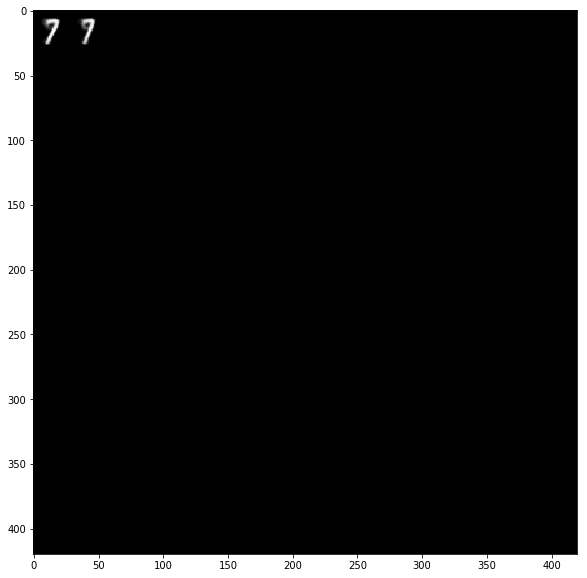

In [42]:

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

counter = 0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        if counter <= 1 :
            z_sample = np.array([[xi, yi]]) 
            print('z_sample: ', z_sample)
            x_decoded = generator.predict(z_sample)
            print('x_decoded: ', x_decoded)
            print('x_decoded.shape: ', x_decoded.shape)
            
            print('x_decoded[0]: ', x_decoded[0])
            print('x_decoded[0].shape: ', x_decoded[0].shape)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            
            print('digit: ', digit)
            print('digit.shape: ', digit.shape)
            
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            
            print('figure: ', figure)
            print('figure.shape: ', figure.shape)
            
            counter +=1
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()